In [2]:
from copy import deepcopy
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.decomposition import PCA

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis import distances

import nglview as nv

import warnings
warnings.filterwarnings("ignore")

The simulations in this tutorial are taken from: [M.T. Degiacomi (2019). Coupling Molecular Dynamics and Deep Learning to Mine Protein Conformational Space. Structure.](https://doi.org/10.1016/j.str.2019.03.018)

MurD is a 47-kDa ATP-driven ligase responsible for the biosynthesis of a bacterial peptidoglycan precursor (UDP-N-acetylmuramoyl-L-alanyl-D-glutamate). When bound to its ligand, UDP-N-acetylmuramoyl-L-alanyl-D-alanine, MurD is stabilized in a closed conformation (PDB: [3UAG](https://www.rcsb.org/structure/3UAG)).

In [3]:
folder = "C:\\temp\\Dropbox\\MD_trajectories\\"

In [4]:
universe_closed = mda.Universe(f'{folder}MurD_closed.pdb')
w = nv.show_mdanalysis(universe_closed)
w

NGLWidget(max_frame=2506)

In the absence of UDP-N-acetylmuramoyl-L-alanyl-D-alanine, MurD takes instead an open conformation (PDB: [1E0D](https://www.rcsb.org/structure/1E0D)).

In [5]:
universe_open = mda.Universe(f'{folder}MurD_open.pdb')
w = nv.show_mdanalysis(universe_open)
w

NGLWidget(max_frame=1912)

By taking the closed conformation and manually removing the ligand, the protein switches to an open conformation.

In [6]:
universe_closed_apo = mda.Universe(f'{folder}MurD_closed_apo.pdb')
w = nv.show_mdanalysis(universe_closed_apo)
w

NGLWidget(max_frame=999)

Our objective in this exercises is to assign conformation of the latter simulation to either the closed or the open state.

## Definition of feature extraction methods

The class Featurizer implements different ways of extracting features from a simulation using MDAnalysis. It is implemented to ensure consistency in feature extraction across the different datasets in the remainder of this exercises. Run this cell as-is.

In [10]:
class Featurizer(object):
    
    def __init__(self, feature):

        if feature == "ramachandran":
            self.get_features = self._get_features_ramachandran
        elif feature == "distance matrix":    
            self.get_features = self._get_features_distance_matrix
        elif feature == "coordinates":    
            self.get_features = self._get_features_coordinates
        else:
            raise Exception("Features extraction method %s not recognised"%feature)
 

    def _get_features_coordinates(self, universe):
        '''
        alpha carbons coordinates
        '''
        crds = []
        ca = universe.select_atoms("name CA")
        for ts in universe.trajectory:
            crds.append(ca.positions.flatten())

        return np.array(crds)


    def _get_features_ramachandran(self, universe):
        '''
        dihedral angles
        '''
        r = Ramachandran(universe.select_atoms('protein')).run()
        return r.angles.reshape((r.angles.shape[0], np.prod(r.angles.shape[1:])))


    def _get_features_distance_matrix(self, universe):
        '''
        distance matrix (lower diagonal)
        '''
        crds = []
        ca = universe.select_atoms("name CA")
        for ts in universe.trajectory:
            crds.append(distances.self_distance_array(ca.positions))

        return np.array(crds)


    def _get_features_opening(self, universe, sel1, sel2, sel3):
        '''
        angle between three different regions.
        '''
        pass


The following is a function converting features extracted from different classes into training and test sets ready for classification (run the cell as-is).

In [12]:
def generate_train_test_sets(features, test_size=200, verbose=True):
    '''
    Assemble training and test set along with their lables
    '''

    x_train_crds = []
    x_test_crds = []
    for i, crds in enumerate(features):

        #randomly separate features in training and test set
        indices = np.random.permutation(len(crds))
        indicestrain = np.sort(indices[test_size:])
        indicestest = np.sort(indices[:test_size])

        # build training set
        x_train = deepcopy(crds[indicestrain])
        x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
        x_train_crds.append(x_train) 

        # build test set
        x_test = deepcopy(crds[indicestest])
        x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))
        x_test_crds.append(x_test)

    # aggregate training and test set, and create classification for both
    train_set = np.concatenate(x_train_crds)
    test_set = np.concatenate(x_test_crds)
    train_class = np.concatenate((np.zeros(x_train_crds[0].shape[0]), np.ones(x_train_crds[1].shape[0])))
    test_class = np.concatenate((np.zeros(x_test_crds[0].shape[0]), np.ones(x_test_crds[1].shape[0])))

    if verbose:
        print(f'Training set: {train_set.shape[0]} examples')
        print(f'Test set: {test_set.shape[0]} examples')

    return train_set, test_set, train_class, test_class

## Preparation and analysis of training set

We are now ready to collect features from two independent simulations of the closed and open state of MurD. 

In [14]:
# select a desired type of features
feature = "distance matrix"
F = Featurizer(feature)

# extract features from the simulations of the closed state
feat_closed = F.get_features(universe_closed)
print(f'closed state: {feat_closed.shape[0]} conformations, {feat_closed.shape[1]} features')

# extract features from the simulation of the open state
feat_open = F.get_features(universe_open)
print(f'open state: {feat_open.shape[0]} conformations, {feat_open.shape[1]} features')

closed state: 2507 conformations, 95266 features
open state: 1913 conformations, 95266 features


Let's now convert the features we just extrated in datasets ready for classification.

In [15]:
train_set, test_set, train_class, test_class = generate_train_test_sets([feat_closed, feat_open])

Training set: 4020 examples
Test set: 400 examples


Before going further, it is a good idea to take look at the training data we have just produced by projecting it on a lower dimensional space using Principal Components Analysis (PCA).

In [16]:
pca = PCA(n_components=2)
pca.fit(train_set)
ts = pca.transform(train_set)

Text(0, 0.5, 'PC 2, 2.10%')

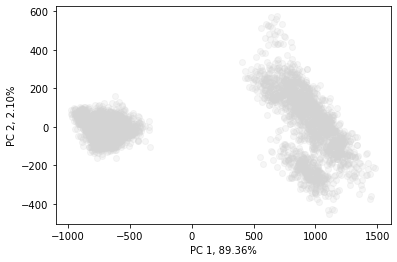

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(ts[:,0], ts[:,1], alpha=0.2, color="lightgray")
ax.set_xlabel(f'PC 1, {pca.explained_variance_ratio_[0]*100:3.2f}%')
ax.set_ylabel(f'PC 2, {pca.explained_variance_ratio_[1]*100:3.2f}%')

Is the data well-separated? What does this tell us about the features?

In [18]:
# @TODO could cluster the eigenspace and compare classification with ground truth

## Training a Random Forests classifier on input data

Let's start by training the classifier using the training set we have just assembled

In [19]:
RF = ExtraTreesClassifier(n_estimators=50) # or RandomForestClassifier
RF.fit(train_set, train_class)

ExtraTreesClassifier(n_estimators=50)

Let's now assess its performance against the test set.

In [20]:
r = RF.predict(test_set)
success = np.sum((r-test_class)==0)
percent = float(success)/len(test_class)*100
print(f'Success of test set: {percent}%')

Success of test set: 100.0%


To see which features are deemed the most useful for a successful classification, we can observe their importance.

In [21]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

if feature == "distance matrix": 
    
    # get indices of most important CA atoms pair
    na = len(universe_closed.select_atoms('name CA'))
    pos = np.array(np.triu_indices(na))[:, np.argmax(std)].T
    
    # retrieve their identity
    ca1 = universe_closed.select_atoms('name CA')[pos[0]]
    ca2 = universe_closed.select_atoms('name CA')[pos[1]]
    print(f'Most relevant distance: {ca1.resname}{ca1.resid} - {ca2.resname}{ca2.resid}')

Most relevant distance: SER56 - ASP336


## Classification of conformations from new simulation

It is now time to characterize the simulation of a trajectory switching to the closed to the open state.

In [22]:
feat = F.get_features(universe_closed_apo)
r = RF.predict(feat)

Let's have a look at the classification. This can be done with a simple colorbar, where different colours represent different classes.

Text(0.5, 0, 'conformation / #')

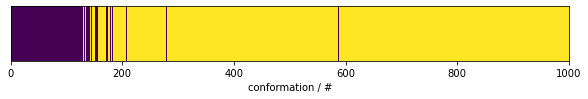

In [23]:
fig = plt.figure(1, figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh([r])
ax.set_yticks([])
ax.set_xlabel("conformation / #")

Let's compare the three datasets (closed, open, and open apo) according to the value most important feature according to the classifier.

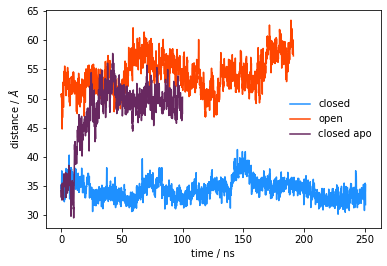

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(len(feat_closed))/10., feat_closed[:, np.argmax(std)], label="closed", color="dodgerblue")
ax.plot(np.arange(len(feat_open))/10., feat_open[:, np.argmax(std)], label="open", color="orangered")
ax.plot(np.arange(len(feat))/10., feat[:, np.argmax(std)], label="closed apo", color="#682860")

ax.set_xlabel("time / ns")
ax.set_ylabel("distance / $\AA$")
ax.legend(frameon=False)

The closed apo simulation appears to take values in its most important feature different from anything seen in the training set. Here we will carry out an outlied detection using an Isolation Forest. More information about outlier detection is available [here](https://scikit-learn.org/stable/modules/outlier_detection.html). The following cell may take some time to run (a few minutes).

In [160]:
clf = IsolationForest(n_estimators=50, warm_start=True)
clf.fit(train_set)

#y_pred_test = clf.predict(test_set)
y_closed_apo = clf.predict(feat)

Text(0.5, 0, 'conformation / #')

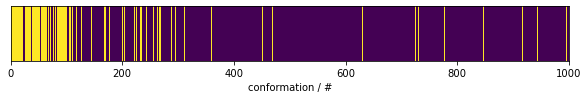

In [163]:
fig = plt.figure(1, figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh([y_closed_apo])
ax.set_yticks([])
ax.set_xlabel("conformation / #")

There seem to be quite a few outliers, what does this tell us about the closed-apo simulation?

The classification we obtained tells us that the second part of the simulation is more similar to the open than the closed state, however its conformations are not consistent with those sampled by the open simulations.

Text(0, 0.5, 'PC 2, 2.11%')

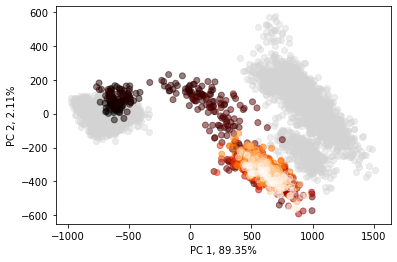

In [222]:
ts2 = pca.transform(feat)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(ts[:,0], ts[:,1], alpha=0.4, c="lightgrey") 
ax.scatter(ts2[:,0], ts2[:,1], alpha=0.5, c=np.arange(len(ts2)), cmap="gist_heat") 
ax.set_xlabel(f'PC 1, {pca.explained_variance_ratio_[0]*100:3.2f}%')
ax.set_ylabel(f'PC 2, {pca.explained_variance_ratio_[1]*100:3.2f}%')